In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import shutil

# Constants
ORIG_DATA = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
CLEAN_DATA = '/kaggle/working/CatsDogsClean'
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 5


In [37]:
# Copy dataset to writable location
shutil.copytree(ORIG_DATA, CLEAN_DATA)

# Remove corrupted images
for label in ['Cat', 'Dog']:
    folder = pathlib.Path(CLEAN_DATA) / label
    for file in folder.iterdir():
        try:
            with Image.open(file) as img:
                img.verify()
        except:
            try:
                file.unlink()
            except:
                pass


In [38]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    CLEAN_DATA,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=42
)

val_gen = datagen.flow_from_directory(
    CLEAN_DATA,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=42
)


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [39]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 423s 672ms/step - accuracy: 0.5964 - loss: 0.6532 - val_accuracy: 0.7625 - val_loss: 0.4909 - learning_rate: 0.0010
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 432s 690ms/step - accuracy: 0.7597 - loss: 0.4933 - val_accuracy: 0.7983 - val_loss: 0.4350 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 425s 680ms/step - accuracy: 0.8205 - loss: 0.4132 - val_accuracy: 0.8119 - val_loss: 0.4140 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 432s 664ms/step - accuracy: 0.8434 - loss: 0.3617 - val_accuracy: 0.8149 - val_loss: 0.4293 - learning_rate: 0.0010
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 422s 675ms/step - accuracy: 0.8911 - loss: 0.2650 - val_accuracy: 0.8509 - val_loss: 0.3450 - learning_rate: 5.0000e-04


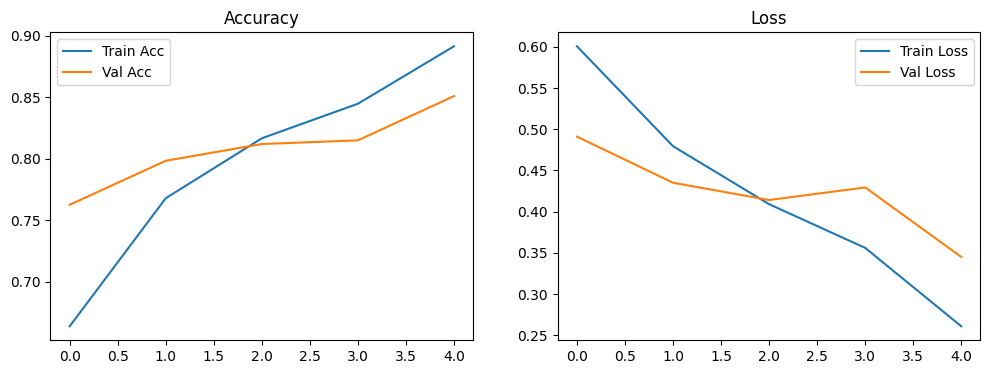

In [41]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


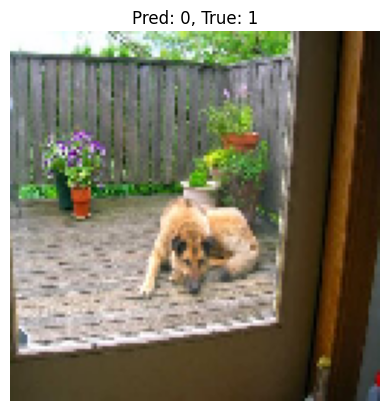

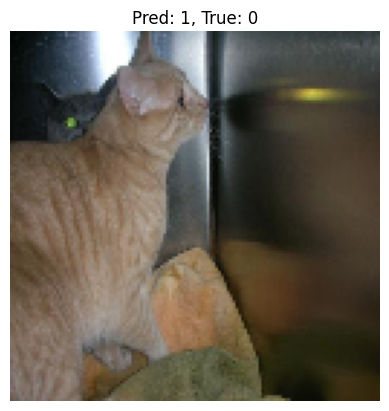

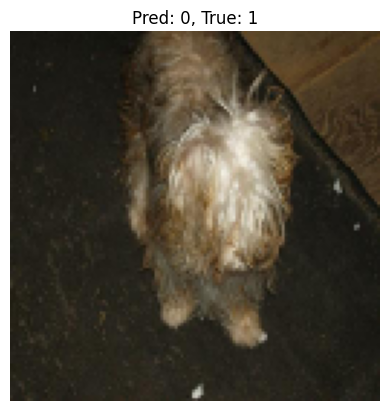

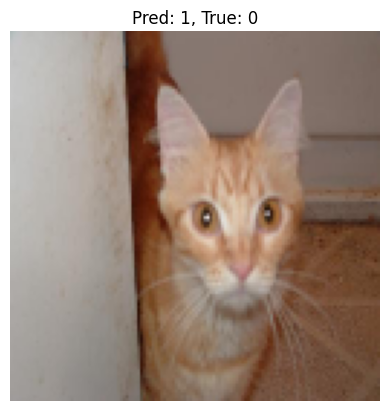

In [42]:
import numpy as np

val_images, val_labels = next(val_gen)
preds = model.predict(val_images)
pred_classes = (preds > 0.5).astype("int32")

misclassified = np.where(pred_classes.flatten() != val_labels)[0]

for i in misclassified[:5]:
    plt.imshow(val_images[i])
    plt.title(f"Pred: {pred_classes[i][0]}, True: {int(val_labels[i])}")
    plt.axis('off')
    plt.show()
